# Budget allocation proposal

This notebook holds the data analysis and text for the budget allocation problem, exemplifying a few concepts as well as doing basic analysis of invested cost and yielded sessions & revenue.

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

validDf = pd.read_csv("../data/valid_dataset_minimal.csv")
campaigns = validDf["Campaign"].unique()
validDf["Date"] = pd.to_datetime(validDf["Date"])
validDf = validDf.drop(columns=["Unnamed: 0"])
print(validDf.replace("1000557 | GA | US | en | Hybrid | GDN Remarketing", "Remarketing").head(10))

        Date   Cost  Revenue Medium          Campaign  Sessions
0 2018-02-26   8.47     0.00    cpc  AW - Accessories        38
1 2018-02-26   0.68     0.00    cpc  AW - Accessories        13
2 2018-02-26   0.01     0.00    cpc  AW - Accessories         1
3 2018-02-26   0.22     0.00    cpc      AW - Apparel         1
4 2018-02-26  77.49     0.00    cpc       Remarketing        24
5 2018-02-26  17.89     0.00    cpc       Remarketing        25
6 2018-02-26   2.94     0.00    cpc       Remarketing         5
7 2018-02-27  12.14    96.94    cpc  AW - Accessories        48
8 2018-02-27   0.93     0.00    cpc  AW - Accessories        22
9 2018-02-27   1.09     0.00    cpc  AW - Accessories         2


## 1. Recap

Let's start with a plot from the first notebook, where, for each valid campaign, I plot the daily cost, number of sessions and revenue.

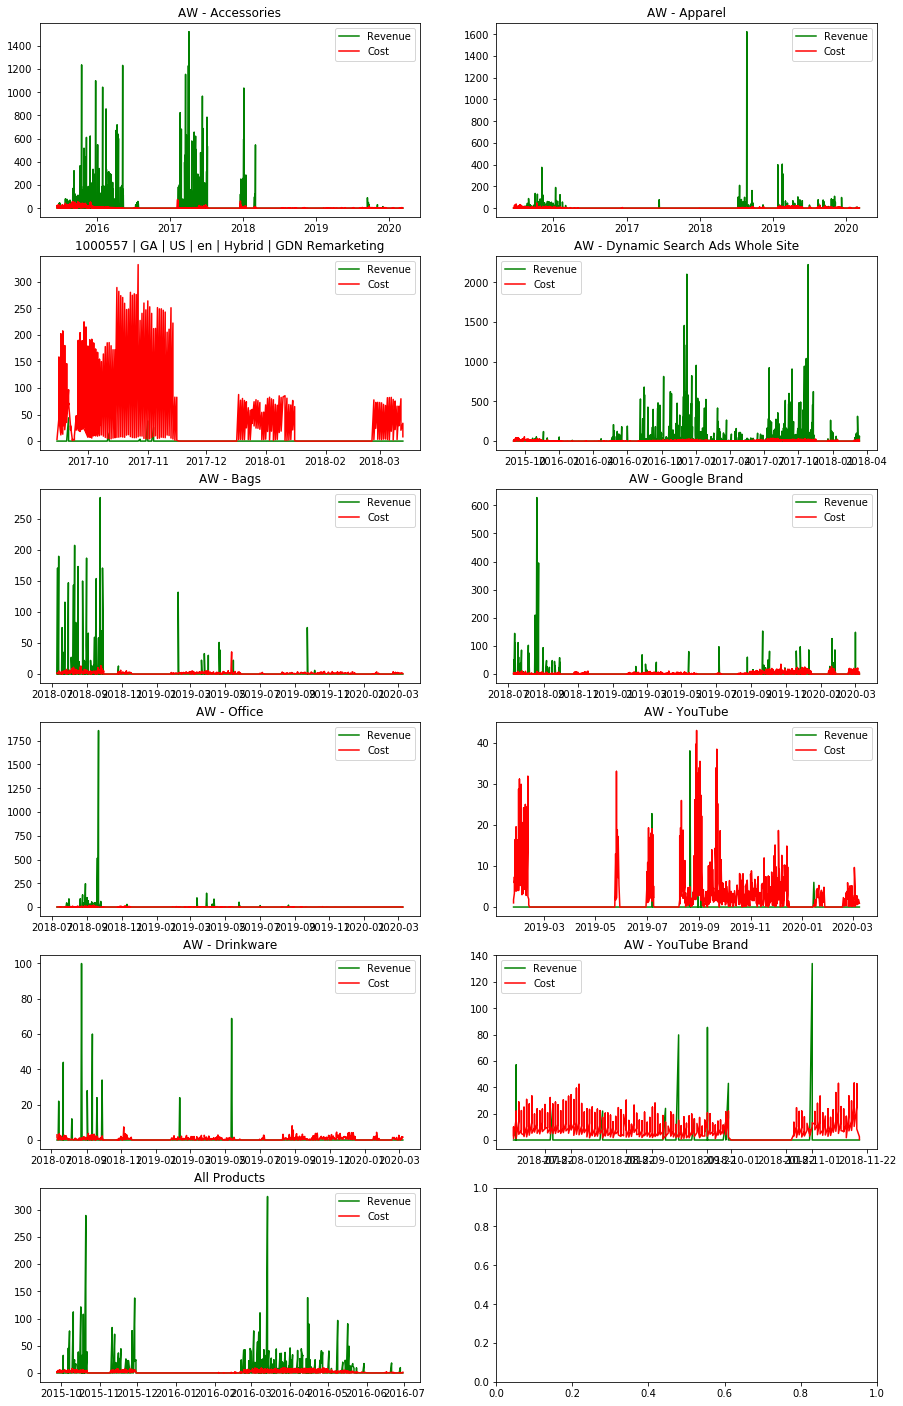

In [2]:
# Do a list of all dates between earliest and latest
nRows = len(campaigns)
ax = plt.subplots(nRows // 2 + 1, 2, figsize=(15, 25))[1]

for i, campaign in enumerate(campaigns):
    dfRelevant = validDf[validDf["Campaign"] == campaign]
    dateRange = pd.DataFrame({
        "Date" : pd.date_range(dfRelevant["Date"].min(), dfRelevant["Date"].max(), freq="D"),
    })
    # Fill missing months by zeros
    dfRelevant = dateRange.set_index("Date").join(dfRelevant.set_index("Date")).fillna(0).reset_index()

    ax[i//2, i%2].plot(dfRelevant["Date"], dfRelevant["Revenue"], color="green")
    ax[i//2, i%2].plot(dfRelevant["Date"], dfRelevant["Cost"], color="red")
    ax[i//2, i%2].set_title(campaign)
    ax[i//2, i%2].legend(["Revenue", "Cost"])

We see that, each campaign has some investment, and then that investment yields some user sessions and some revenue. However, we have no idea what investment is correlated to what change in revenue. The data only tells us daily information: how much we invested today

## 2. First-revenue assumption

### 2.1 Dataset creation

Let's start with the campaign "All Products", a it seems that there are a lot of revenues there. (TO update to all)

In [3]:
def getDataFirstRevenue(df, campaign):
    df = df.loc[df["Campaign"] == campaign].reset_index()[["Date", "Cost", "Revenue"]]
    tmpRevenues = df.loc[df["Revenue"] > 0, "Revenue"]
    indexesL, indexesR = np.array([0, *tmpRevenues.index[0 : -1]]), tmpRevenues.index.to_numpy()
    nRows = len(indexesL)

    costs, revenues, tmpRevenue = [], [], []
    for i in range(nRows):
        tmpRevenue.append(tmpRevenues.iloc[i])
        indexLeft, indexRight = indexesL[i], indexesR[i]
        items = df.loc[(df.index >= indexLeft) & (df.index < indexRight), "Cost"]

        # Consecutive revenues may also have cost of 0 between them, so we skip those and sum the revenues
        if items.sum() > 0:
            costs.append(items.to_numpy())
            revenues.append(np.array(tmpRevenue))
            tmpRevenue = []
#     print("Costs and revenues count: %d" % (len(costs)))

    # Now, we got a list of:
    #  costs: [[c11, c12, c13], [c21, 22], ..., [cN1, cNk]]
    #  revenues: [[r11, r12], [r21], [r31], ..., [rN1, rNk]]
    return np.array(costs), np.array(revenues)

X, t = {}, {}
for campaign in campaigns:
    costs, revenues = getDataFirstRevenue(validDf, campaign)
    if len(costs) < 20:
        continue
    X[campaign] = costs
    t[campaign] = revenues
    print("Campaign: %s. Shapes: %s %s" % (campaign, X[campaign].shape, t[campaign].shape))

Campaign: AW - Accessories. Shapes: (452,) (452, 1)
Campaign: AW - Apparel. Shapes: (138,) (138, 1)
Campaign: AW - Dynamic Search Ads Whole Site. Shapes: (382,) (382, 1)
Campaign: AW - Bags. Shapes: (52,) (52, 1)
Campaign: AW - Google Brand. Shapes: (56,) (56, 1)
Campaign: AW - Office. Shapes: (36,) (36, 1)
Campaign: All Products. Shapes: (109,) (109, 1)


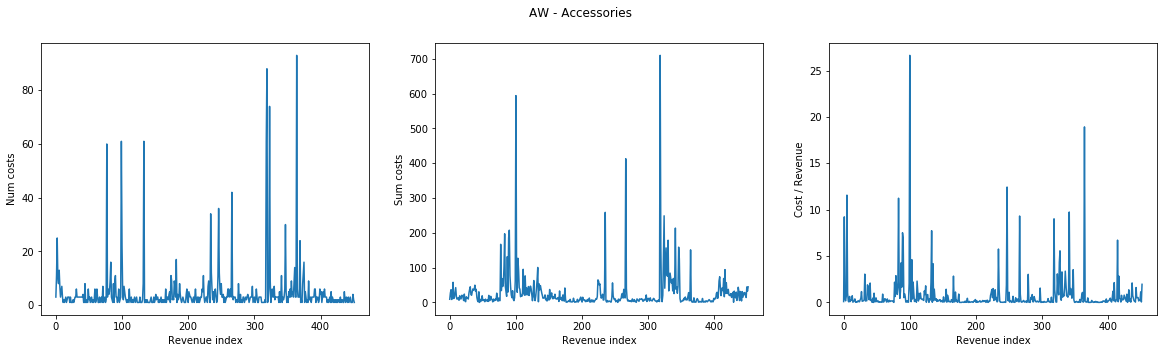

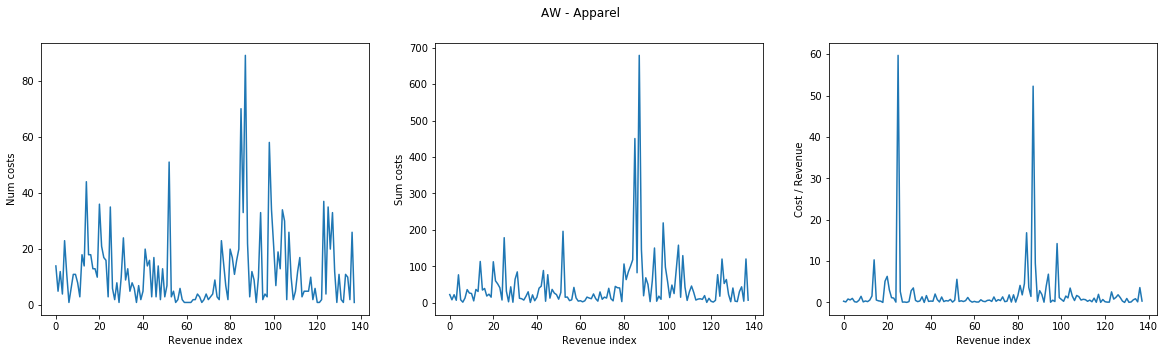

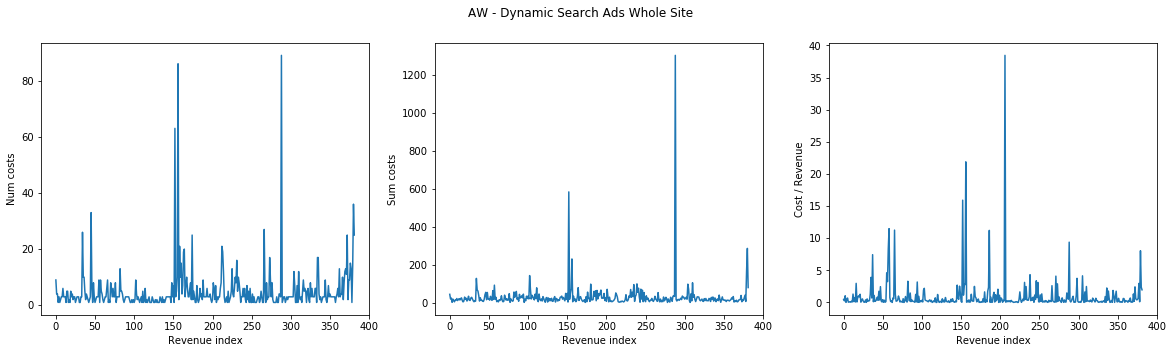

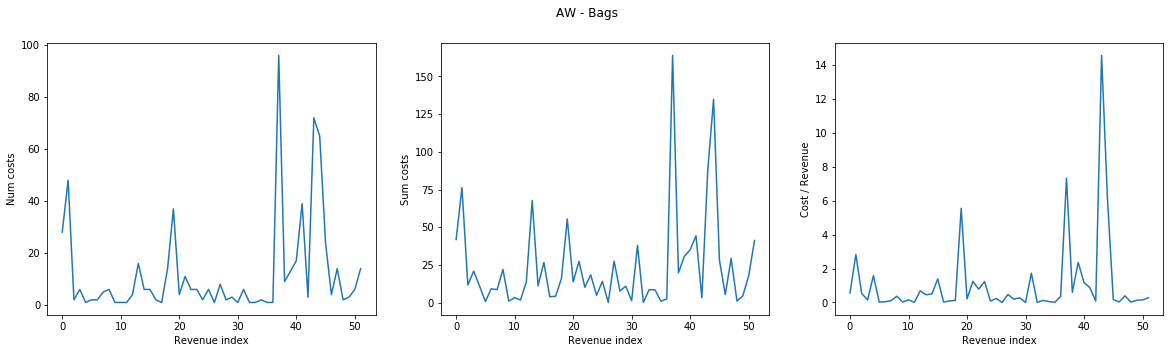

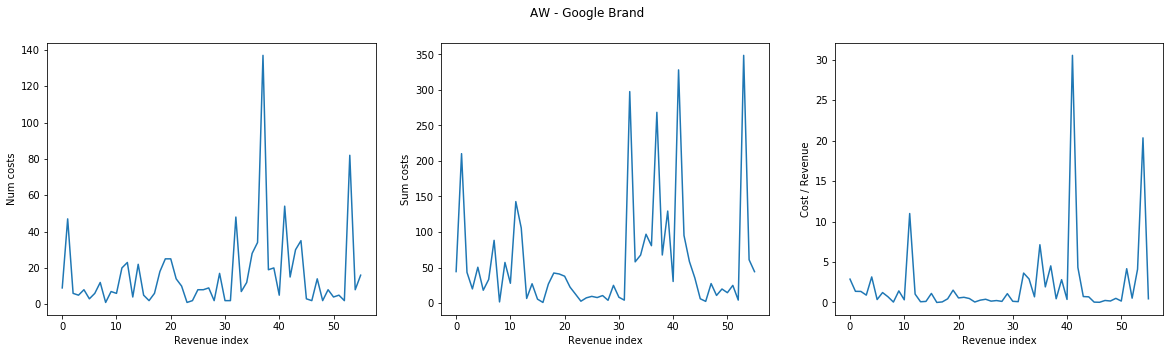

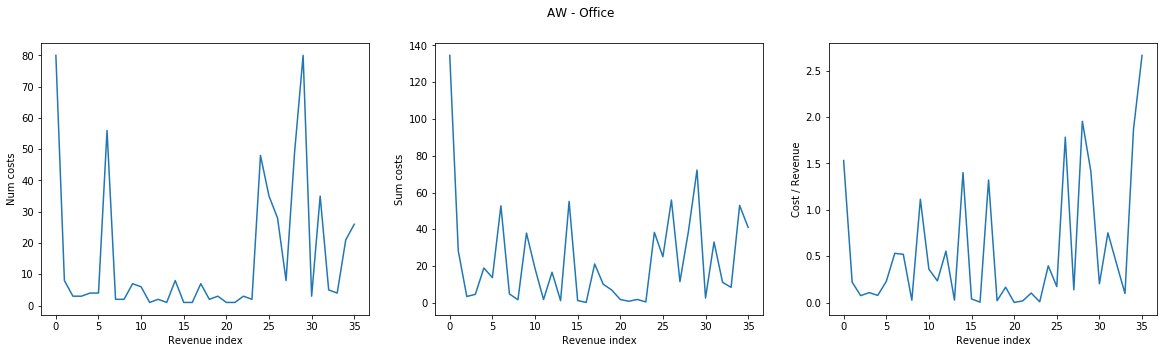

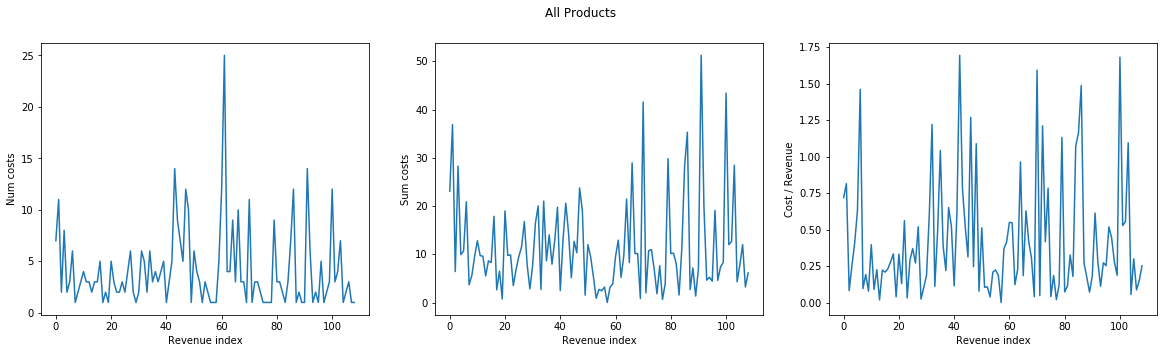

In [4]:
for campaign in X.keys():
    costs, revenues = X[campaign], t[campaign]
    numCosts = np.array([len(x) for x in costs])
    sumCosts = np.array([sum(x) for x in costs])
    rapp = np.array([sum(x) / sum(y) for x, y in zip(costs, revenues)])
    ax = plt.subplots(1, 3, figsize=(20, 5))[1]
    
    ax[0].plot(range(len(numCosts)), numCosts)
    ax[0].set_xlabel("Revenue index")
    ax[0].set_ylabel("Num costs")

    ax[1].plot(range(len(numCosts)), sumCosts)
    ax[1].set_xlabel("Revenue index")
    ax[1].set_ylabel("Sum costs")

    ax[2].plot(range(len(rapp)), rapp)
    ax[2].set_xlabel("Revenue index")
    ax[2].set_ylabel("Cost / Revenue")
    
    plt.gcf().suptitle(campaign)

In [5]:
# However, we only use the sum of the intermitent inner lists in the first-revenue assumption
X = {k : np.expand_dims(np.array([x.sum() for x in X[k]]), axis=-1) for k in X}
t = {k : np.expand_dims(np.array([x.sum() for x in t[k]]), axis=-1) for k in t}

### 2.2 Statistical model (Notebook 2)

In [6]:
class StatisticalModel:
    def __init__(self):
        # This model has just a single parameter, computed as the count between targets and inputs
        self.param = np.nan
        
    def fit(self, x, t):
        assert self.param != self.param
        self.param = t.sum() / x.sum()
    
    def predict(self, x):
        assert self.param == self.param
        return x * self.param

class KFold:
    def __init__(self, numSplits, randomState):
        self.randomState = randomState
        assert numSplits > 0
        self.numSplits = numSplits
    
    def split(self, numData):
        np.random.seed(self.randomState)
        perm = np.random.permutation(numData)
        n = numData // self.numSplits
        for i in range(self.numSplits):
            trainIx = list(range(0, i * n)) + list(range((i + 1) * n, numData))
            valIx = list(range(i * n, (i + 1) * n))
            yield perm[trainIx], perm[valIx]

def errorL1(y, t):
    return np.abs(y - t).mean()

def trainModel(X, t, modelType, numSplits, randomState):
    kf = KFold(numSplits=numSplits, randomState=randomState)
    errors = []
    for trainIx, validationIx in kf.split(len(X)):
        model = modelType()
        model.fit(X[trainIx], t[trainIx])
        y = model.predict(X[validationIx])
        errors.append(errorL1(y, t[validationIx]))

    # We report the mean error on all K-fold splits for robustness
    meanError = np.mean(errors)
    
    # Then, we retrain on all data, for best test/future predictions
    model = modelType()
    model.fit(X, t)
    return model, meanError

def trainAllCampaigns(X, t, modelType, numSplits, randomState):
    models, errors = {}, {}
    validCampaigns = list(X.keys())
    for i, campaign in enumerate(validCampaigns):
        model, error = trainModel(X[campaign], t[campaign], modelType, numSplits, randomState)
        models[campaign] = model
        errors[campaign] = error
    return models, errors

### 2.2.1 Train the model on all campaigns

In [7]:
# Store the model for each campaign
models, errors = trainAllCampaigns(X, t, StatisticalModel, numSplits=5, randomState=42)
display(pd.DataFrame([(x, y) for x, y in zip(errors.keys(), errors.values())], columns=["Campaign", "Best error (L1)"]))

,Campaign,Best error (L1)
0,AW - Accessories,190.044511
1,AW - Apparel,80.117334
2,AW - Dynamic Search Ads Whole Site,183.358235
3,AW - Bags,92.514348
4,AW - Google Brand,86.565107
5,AW - Office,170.248227
6,All Products,35.429204


### 2.2.2 Plot the results

Revenue vs. sum(pseudoRevenue)

In [8]:
def plotResults(models, X, t, errors):
    validCampaigns = list(models.keys())
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        campaignX = X[campaign]
        campaignT = t[campaign]
        y = models[campaign].predict(campaignX)
        error = errors[campaign]
        ax[i//2, i%2].scatter(campaignX, y)
        ax[i//2, i%2].scatter(campaignX, campaignT)
        ax[i//2, i%2].set_title("Campaign: %s. Error %2.3f" % (campaign, error))
        ax[i//2, i%2].legend(["sum(Cost) x sum(Pseudo Revenue)", "sum(Cost) x sum(Revenue)"])

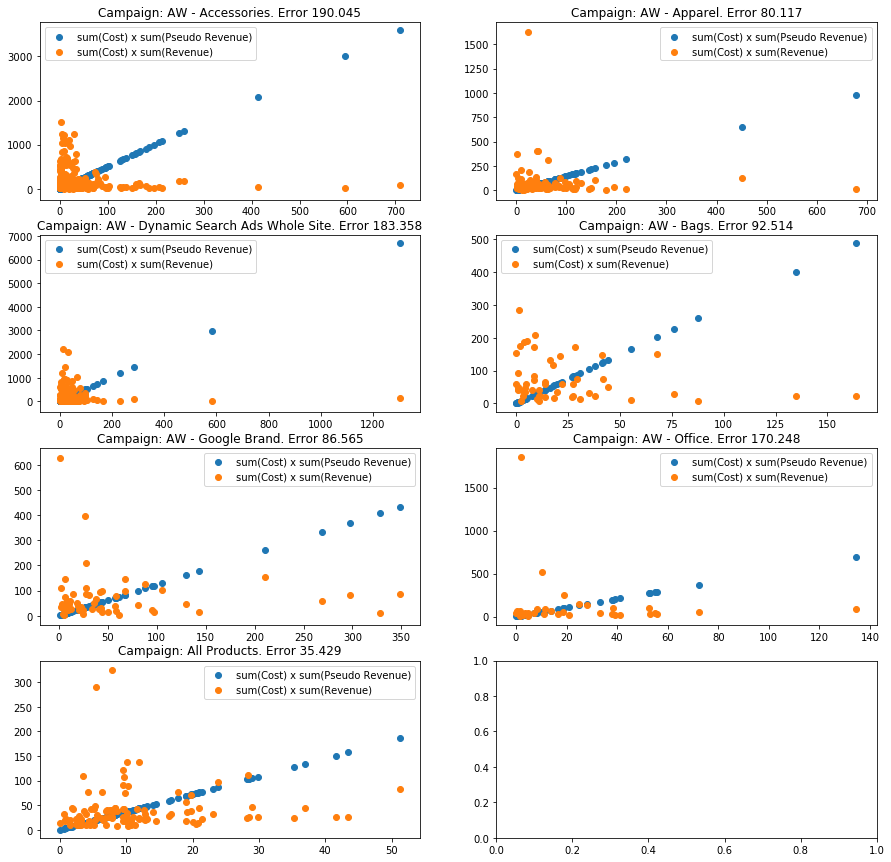

In [9]:
plotResults(models, X, t, errors)

### 2.2.3 Create pseudo-revenues for all costs

In [10]:
from typing import Tuple, List

def createPseudoRevenues(models : List, df : pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    validCampaigns = models.keys()
    finalDf = pd.DataFrame(columns=df.columns)
    for i, campaign in enumerate(validCampaigns):
        dfCampaign = df[df["Campaign"] == campaign].reset_index()
        dfCampaign["Pseudo Revenue"] = models[campaign].predict(np.expand_dims(dfCampaign["Cost"], axis=-1))
        finalDf = pd.concat([finalDf, dfCampaign], sort=False)
    return finalDf

In [11]:
finalDf = createPseudoRevenues(models, validDf)

### 2.2.4 Print the overall error

In [12]:
def getOverallError(df):
    return df.groupby("Campaign").apply(lambda x : pd.Series({
        "Cost" : x["Cost"].sum(),
        "Revenue": x["Revenue"].sum(),
        "Pseudo Revenue": x["Pseudo Revenue"].sum(),
        "Diff" : x["Revenue"].sum() - x["Pseudo Revenue"].sum()
    })).reset_index()

In [13]:
overallError = getOverallError(finalDf)
display(overallError)

,Campaign,Cost,Revenue,Pseudo Revenue,Diff
0,AW - Accessories,12643.27,63700.71,63959.872723,-259.162723
1,AW - Apparel,6351.59,9104.17,9139.712423,-35.542423
2,AW - Bags,1357.74,3721.28,4045.779049,-324.499049
3,AW - Dynamic Search Ads Whole Site,11212.15,57540.27,57561.061936,-20.791936
4,AW - Google Brand,3329.69,4122.77,4130.274651,-7.504651
5,AW - Office,832.96,4269.28,4286.622873,-17.342873
6,All Products,1249.34,4502.51,4526.021518,-23.511518


### 2.2.5 Plot Cost vs PseudoRevenue

In [14]:
def plotFinalResults(df, overallError):
    validCampaigns = df["Campaign"].unique()
    ax = plt.subplots(len(validCampaigns) // 2 + 1, 2, figsize=(15, 15))[1]
    for i, campaign in enumerate(validCampaigns):
        dfCampaign = df[df["Campaign"] == campaign]
        dateRange = pd.DataFrame({
            "Date" : pd.date_range(dfCampaign["Date"].min(), dfCampaign["Date"].max(), freq="D"),
        })
        # Fill missing months by zeros
        dfCampaign = dateRange.set_index("Date").join(dfCampaign.set_index("Date")).fillna(0).reset_index()
        error = overallError.loc[overallError["Campaign"] == campaign, "Diff"].to_numpy()[0]

        ax[i//2, i%2].plot(dfCampaign["Date"], dfCampaign["Pseudo Revenue"])
        ax[i//2, i%2].plot(dfCampaign["Date"], dfCampaign["Cost"])
        ax[i//2, i%2].set_title("Campaign: %s. Overall error: %s" % (campaign, error))
        ax[i//2, i%2].legend(["Pseudo Revenue", "Cost"])

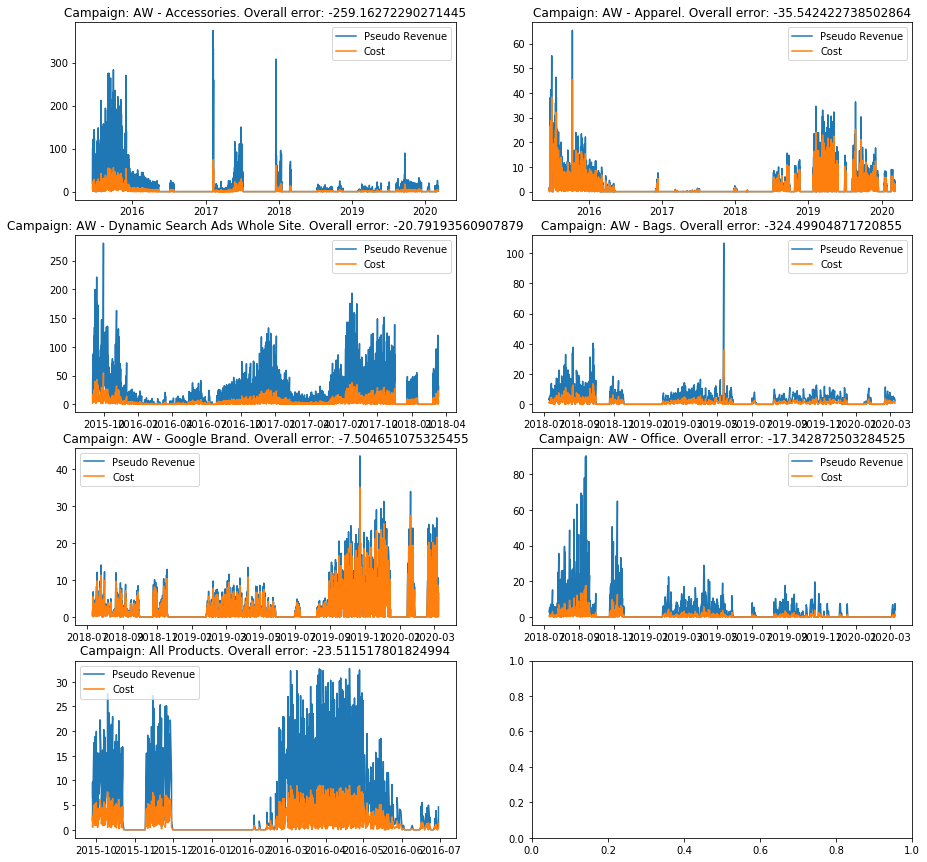

In [15]:
plotFinalResults(finalDf, overallError)

### 2.3 Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
from functools import partial

LR = partial(LinearRegression, fit_intercept=False)
LRModels, LRErrors = trainAllCampaigns(X, t, LR, numSplits=5, randomState=42)
display(pd.DataFrame([(x, y) for x, y in zip(LRErrors.keys(), LRErrors.values())], columns=["Campaign", "Best error (L1)"]))

,Campaign,Best error (L1)
0,AW - Accessories,134.244831
1,AW - Apparel,60.815751
2,AW - Dynamic Search Ads Whole Site,145.131129
3,AW - Bags,69.732021
4,AW - Google Brand,64.023177
5,AW - Office,113.282747
6,All Products,29.785993


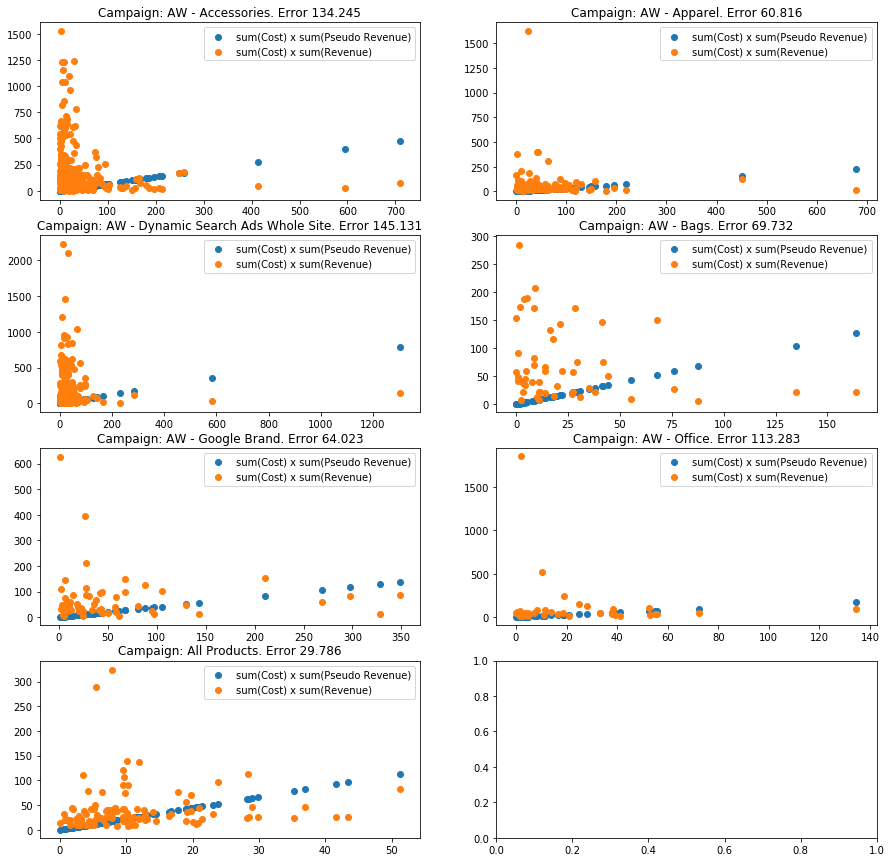

In [17]:
plotResults(LRModels, X, t, LRErrors)

In [21]:
LRFinalDf = createPseudoRevenues(LRModels, validDf)

In [22]:
LROverallError = getOverallError(LRFinalDf)
display(LROverallError)

,Campaign,Cost,Revenue,Pseudo Revenue,Diff
0,AW - Accessories,12643.27,63700.71,8498.362281,55202.347719
1,AW - Apparel,6351.59,9104.17,2147.839427,6956.330573
2,AW - Bags,1357.74,3721.28,1055.037371,2666.242629
3,AW - Dynamic Search Ads Whole Site,11212.15,57540.27,6776.473345,50763.796655
4,AW - Google Brand,3329.69,4122.77,1299.457440,2823.312560
5,AW - Office,832.96,4269.28,1092.582452,3176.697548
6,All Products,1249.34,4502.51,2764.558727,1737.951273


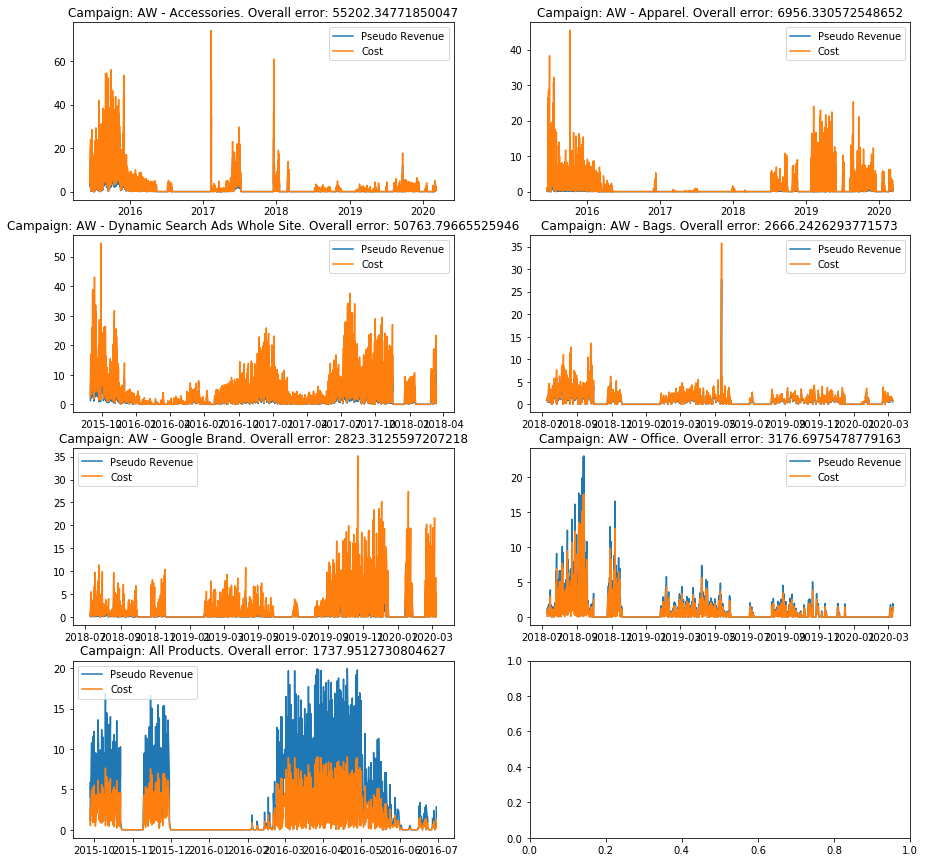

In [23]:
plotFinalResults(LRFinalDf, LROverallError)